# HOMEWORK 1: DIAGNOSTIC 

### PRE-PROCESSING: Preparation of working dataframes

In [5]:
import datetime
from datetime import timedelta
from datetime import datetime, date, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import requests 

###### Functions for building dataframes

In [6]:
def read_files(filen):
    '''
    Reading in downloaded csv files for 311 data for 2017
    '''
    dframe = pd.read_csv(filen)
    return dframe

In [7]:
def cols_upper(dframe):
    '''
    Renames columns to get same format for common variables
    '''
    dframe.rename(columns=lambda x: x.upper(), inplace=True)
    return dframe

In [8]:
def construct_df(a, b, c):
    '''
    Constructs a common dataframe for the downloaded csvs
    '''
    a_lights_df = cols_upper(read_files(a))
    grafitti_df = cols_upper(read_files(b))
    vacant_df = cols_upper(read_files(c))

    #Rename column with different name
    vacant_df.rename(index=str, columns={"SERVICE REQUEST TYPE": "TYPE OF SERVICE REQUEST", "DATE SERVICE REQUEST WAS RECEIVED": "CREATION DATE"}, inplace=True)

    total_df = pd.concat([a_lights_df, grafitti_df, vacant_df])
    total_df.reset_index(inplace = True)

    #Creates new columns with information datetime format. 
    
    total_df['CREATION DATE F'] = total_df['CREATION DATE'].apply(pd.to_datetime) 
    total_df['COMPLETION DATE F'] = total_df['COMPLETION DATE'].apply(pd.to_datetime) 
    total_df['RESPONSE TIME'] = (total_df['COMPLETION DATE F'] - total_df['CREATION DATE F'])
    total_df['RESPONSE TIME'] =  total_df['RESPONSE TIME'].map(lambda x: np.nan if pd.isnull(x) else x.days)
    
    return total_df

In [9]:
def get_fips(lat, lon):
    url=  "https://geo.fcc.gov/api/census/block/find?latitude={}&longitude={}&format=json".format(lat, lon)
    r = requests.get(url)
    r_dic = r.json()
    fips = r_dic["Block"]["FIPS"]
    return fips

In [10]:
#Data for pt two: 
def update_with_census(df):
    d = date(2017, 10, 1)
    df2 = df[df["TYPE OF SERVICE REQUEST"] != "Graffiti Removal"]
    df3 = df2[df2["CREATION DATE F"] > d ]
    df3 = df3.dropna(subset=["LATITUDE", "LONGITUDE"])
    df3['BLOCK FIPS'] =  df3.apply(lambda x: get_fips(x["LATITUDE"], x["LONGITUDE"]), axis = 1)
    df3['STATE + COUNTY'] = df3.apply(lambda x: x["BLOCK FIPS"][:5], axis = 1)
    df3['TRACT'] = df3.apply(lambda x: x["BLOCK FIPS"][5:11], axis = 1)
    df3 = df3.set_index('TRACT')
    
    return df3 

In [25]:
#Updated variables used 
def get_tract_info(k):
    state = "17" #Hardcoded for the case of Illinois / Cook County 
    county = "031"
    var = "NAME,DP03_0119PE,DP05_0032PE,DP03_0051PE,DP02_0058PE,DP02_0015E,DP02_0052PE"
    get_ = "?get=" + var
    for_ = "&for=tract:*" + "&in=state:"+ state + "+county:" + county 
    key_ = "&key=" + k
    STR = "https://api.census.gov/data/2015/acs5/profile" + get_ + for_ + key_
    r = requests.get(STR)
    info_dict = r.json()
    
    tract_census_frame = pd.DataFrame(info_dict[1:], columns = ["NAME","PERCENTAGE OF FAM BELOW POVERTY LINE", "ONE RACE - WHITE","INCOME AND BENEFITS(MEAN)","EDUCATIONAL ATTAINMENT (25 AND OVER)","AVG HOUSEHOLD SIZE","SCHOOL ENROLLEMENT","STATE","COUNTRY","TRACT"])
    tract_census_frame = tract_census_frame.set_index('TRACT')
    
    return tract_census_frame

In [12]:
def join_dframes(df1, df2):
    result = pd.concat([df1, df2], axis=1, join='inner')
    return result

###### Creation of all pertinent dataframes

In [14]:
a_filename = "Data/311_Service_Requests_-_Alley_Lights_Out.csv"
g_filename = "Data/311_Service_Requests_-_Graffiti_Removal.csv"
v_filename = "Data/311_Service_Requests_-_Vacant_and_Abandoned_Buildings_Reported.csv"
KEY = "a3d7f7cc3bd0e3cb55975f1c70c7aeb4d400fcdb"

threeoneone_df = construct_df(a_filename, g_filename, v_filename)
census_frame = update_with_census(threeoneone_df)
tract_frame = get_tract_info(KEY)
complete_frame = join_dframes(census_frame, tract_frame)

## PROBLEM 1

#### Problem 1 - Part 2: Summary statistics

In [17]:
# Types of Service Requests, general: 

print("\nType of Service Request: COUNTS \n \n{}".format(threeoneone_df["TYPE OF SERVICE REQUEST"].value_counts()))
print("\nType of Service Request: PERCENTAGE \n \n{}".format(threeoneone_df["TYPE OF SERVICE REQUEST"].value_counts(True)))


Type of Service Request: COUNTS 
 
Graffiti Removal             112779
Alley Light Out               27896
Vacant/Abandoned Building      3666
Name: TYPE OF SERVICE REQUEST, dtype: int64

Type of Service Request: PERCENTAGE 
 
Graffiti Removal             0.781337
Alley Light Out              0.193265
Vacant/Abandoned Building    0.025398
Name: TYPE OF SERVICE REQUEST, dtype: float64


In [18]:
# Types of Service requests, Graffiti Removal Specific:
print("\nWhat type of surface is the graffiti on?: PERCENTAGE \n \n{}".format(threeoneone_df["WHAT TYPE OF SURFACE IS THE GRAFFITI ON?"].value_counts(True).head(5)))
print("\nWhere is the graffiti located?: PERCENTAGE \n \n{}".format(threeoneone_df["WHERE IS THE GRAFFITI LOCATED?"].value_counts(True).head(5)))


What type of surface is the graffiti on?: PERCENTAGE 
 
Metal - Painted                         0.359125
Brick - Unpainted                       0.173485
Brick - Painted                         0.130305
Metal - Unpainted                       0.088710
Cement (Sidewalk, Alley, Wall, Curb)    0.082085
Name: WHAT TYPE OF SURFACE IS THE GRAFFITI ON?, dtype: float64

Where is the graffiti located?: PERCENTAGE 
 
Front     0.289902
Side      0.132340
Pole      0.115808
Garage    0.071142
Rear      0.060352
Name: WHERE IS THE GRAFFITI LOCATED?, dtype: float64


In [19]:
# Types of Service requests, Vacant and Abandoned buildings specific: 

print("\nIs the building open or boarded?: PERCENTAGE \n \n{}".format(threeoneone_df["IS BUILDING OPEN OR BOARDED?"].value_counts(True).head(5)))
print("\nIs the building vacant or occupied?: PERCENTAGE \n \n{}".format(threeoneone_df["IS THE BUILDING CURRENTLY VACANT OR OCCUPIED?"].value_counts(True).head(5)))
print("\nIs the building vacant due to fire?: PERCENTAGE \n \n{}".format(threeoneone_df["IS THE BUILDING VACANT DUE TO FIRE?"].value_counts(True).head(5)))



Is the building open or boarded?: PERCENTAGE 
 
Open       0.811847
Boarded    0.188153
Name: IS BUILDING OPEN OR BOARDED?, dtype: float64

Is the building vacant or occupied?: PERCENTAGE 
 
Vacant      0.986067
Occupied    0.013933
Name: IS THE BUILDING CURRENTLY VACANT OR OCCUPIED?, dtype: float64

Is the building vacant due to fire?: PERCENTAGE 
 
False    0.901395
True     0.098605
Name: IS THE BUILDING VACANT DUE TO FIRE?, dtype: float64


In [20]:
# Get average response date by each group

#How to show mean results if we don't have information for Vacant or abandoned building 
threeoneone_df.groupby(["TYPE OF SERVICE REQUEST"])["RESPONSE TIME"].mean()

TYPE OF SERVICE REQUEST
Alley Light Out              33.489418
Graffiti Removal              0.676226
Vacant/Abandoned Building          NaN
Name: RESPONSE TIME, dtype: float64

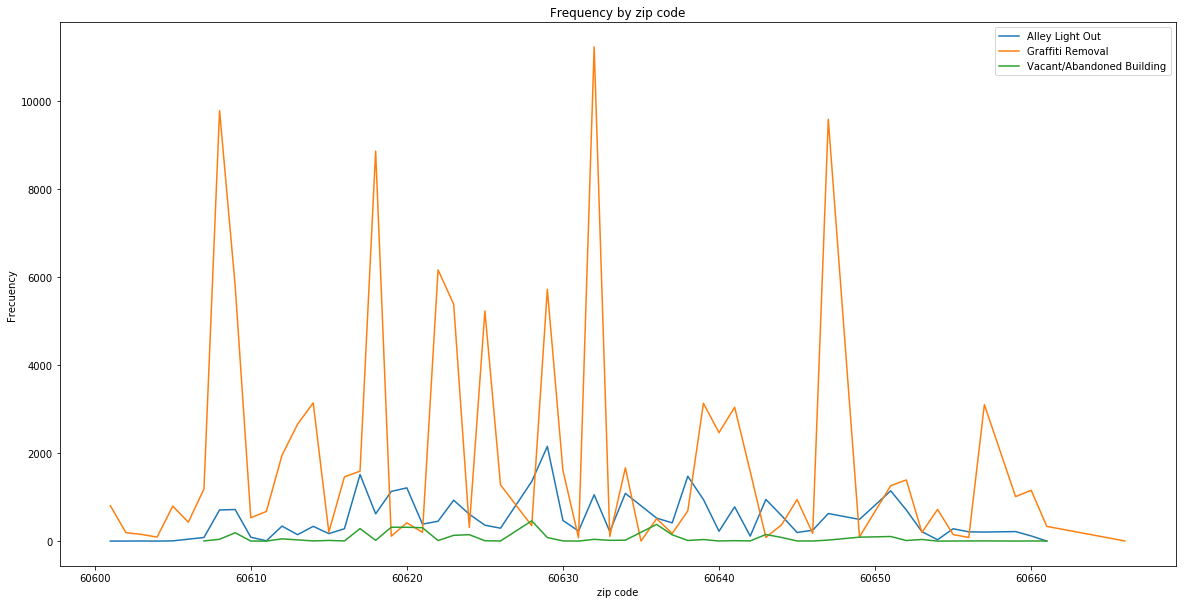

In [26]:
#Get frequencies by zip codes 

dates = threeoneone_df.groupby(['ZIP CODE', 'TYPE OF SERVICE REQUEST']).size().reset_index(name='COUNT')

dates = dates[dates['ZIP CODE'] > 0]
dates = dates[dates['ZIP CODE'] < 60700] #trimming outliers to better visualize information
one = dates[dates['TYPE OF SERVICE REQUEST'] == "Alley Light Out"] 
two = dates[dates['TYPE OF SERVICE REQUEST'] == "Graffiti Removal"] 
three = dates[dates['TYPE OF SERVICE REQUEST'] == "Vacant/Abandoned Building"] 

plt.figure(figsize=(20, 10))
plt.scatter(one["ZIP CODE"], one["COUNT"], label="Alley Light Out")
plt.scatter(two["ZIP CODE"], two["COUNT"], label="Graffiti Removal")
plt.scatter(three["ZIP CODE"], three["COUNT"], label="Vacant/Abandoned Building")

plt.xlabel("zip code")
plt.ylabel("Frecuency")
plt.title("Frequency by zip code")

plt.legend()

plt.show()

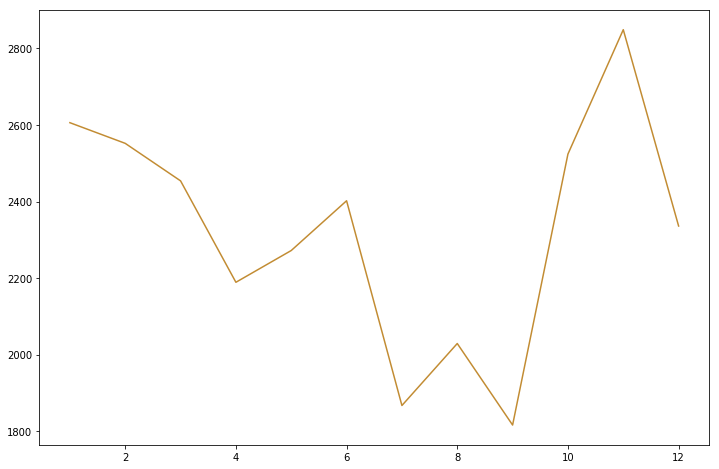

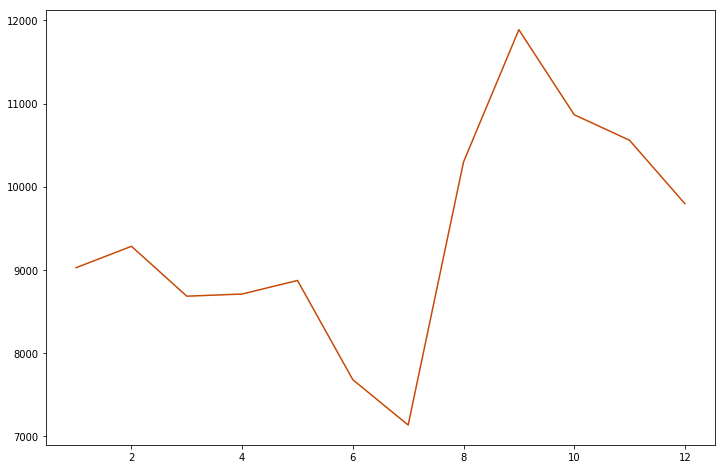

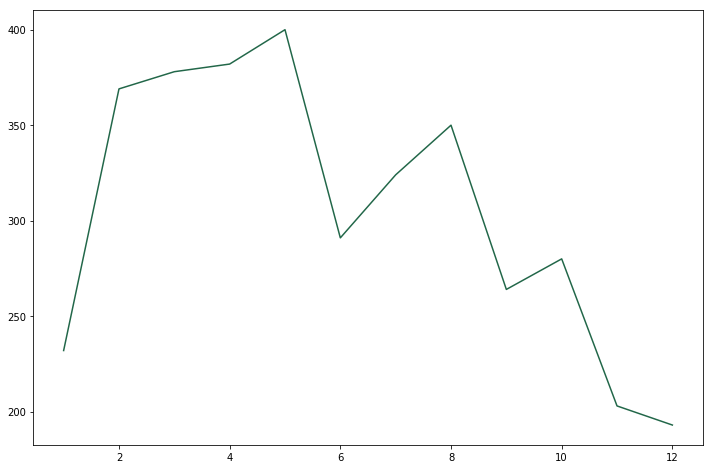

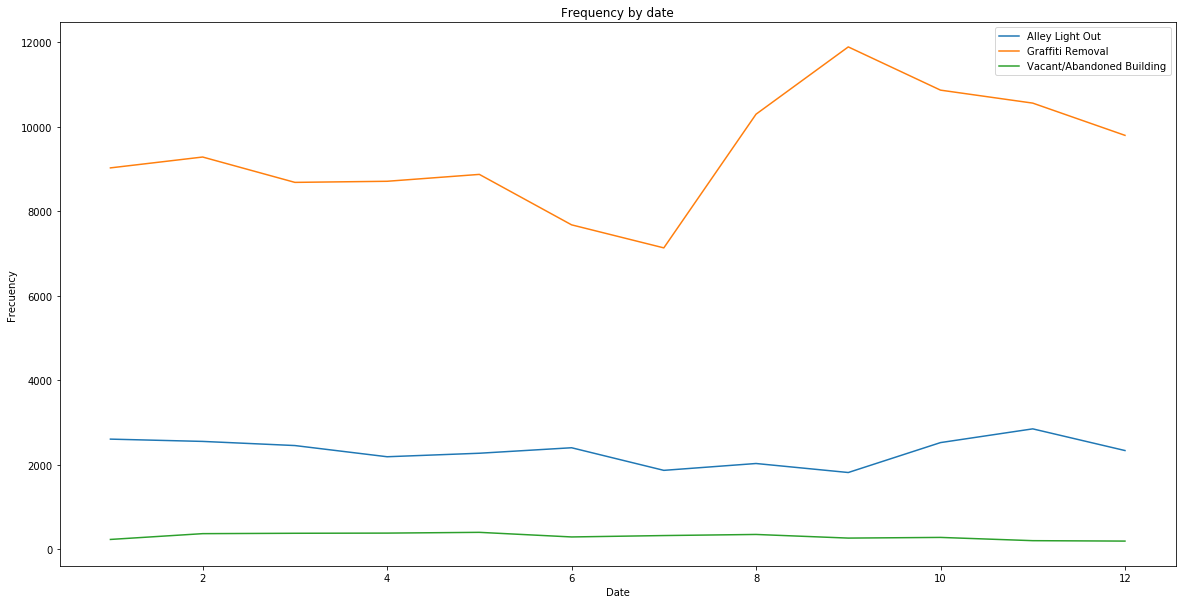

In [25]:
#Get frequencies of each by month
threeoneone_df["MONTH"] = threeoneone_df["CREATION DATE F"].apply(lambda x: x.month)
dates = threeoneone_df.groupby(['MONTH', 'TYPE OF SERVICE REQUEST']).size().reset_index(name='COUNT')
one = dates[dates['TYPE OF SERVICE REQUEST'] == "Alley Light Out"] 
two = dates[dates['TYPE OF SERVICE REQUEST'] == "Graffiti Removal"] 
three = dates[dates['TYPE OF SERVICE REQUEST'] == "Vacant/Abandoned Building"] 
one = dates[dates['TYPE OF SERVICE REQUEST'] == "Alley Light Out"] 
two = dates[dates['TYPE OF SERVICE REQUEST'] == "Graffiti Removal"] 
three = dates[dates['TYPE OF SERVICE REQUEST'] == "Vacant/Abandoned Building"] 

x = one['MONTH']
y = one['COUNT']
plt.figure(figsize=(12, 8))
plt.plot(x, y, c=np.random.rand(3,))
plt.show()

x = two['MONTH']
y = two['COUNT']
plt.figure(figsize=(12, 8))
plt.plot(x, y, c=np.random.rand(3,))
plt.show()

x = three['MONTH']
y = three['COUNT']
plt.figure(figsize=(12, 8))
plt.plot(x, y, c=np.random.rand(3,))
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(one["MONTH"], one["COUNT"], label="Alley Light Out")
plt.plot(two["MONTH"], two["COUNT"], label="Graffiti Removal")
plt.plot(three["MONTH"], three["COUNT"], label="Vacant/Abandoned Building")

plt.xlabel("Date")
plt.ylabel("Frecuency")
plt.title("Frequency by date")

plt.legend()

plt.show()

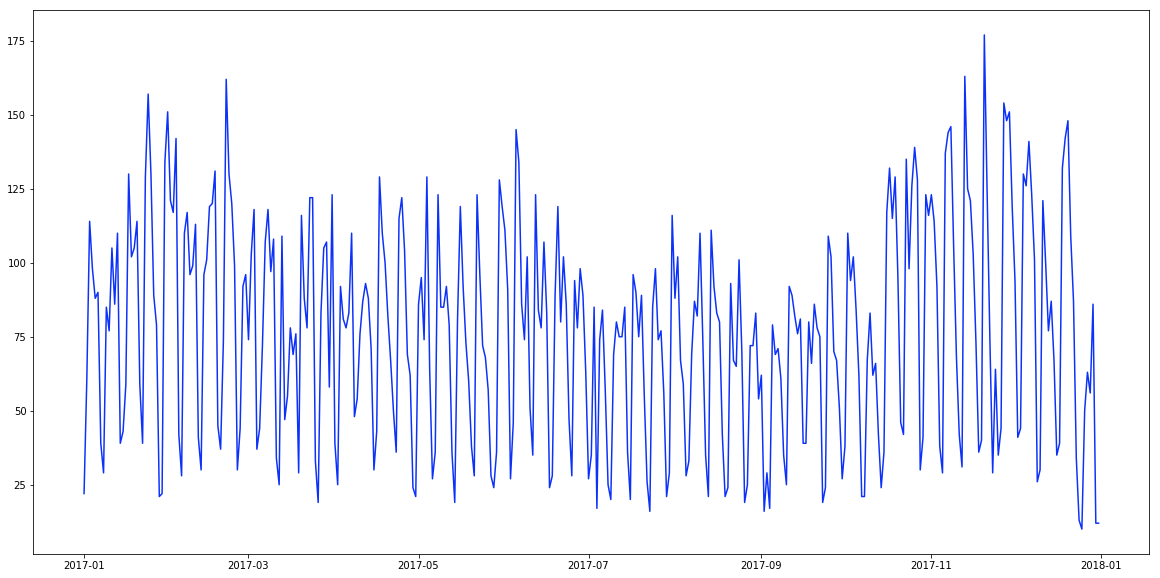

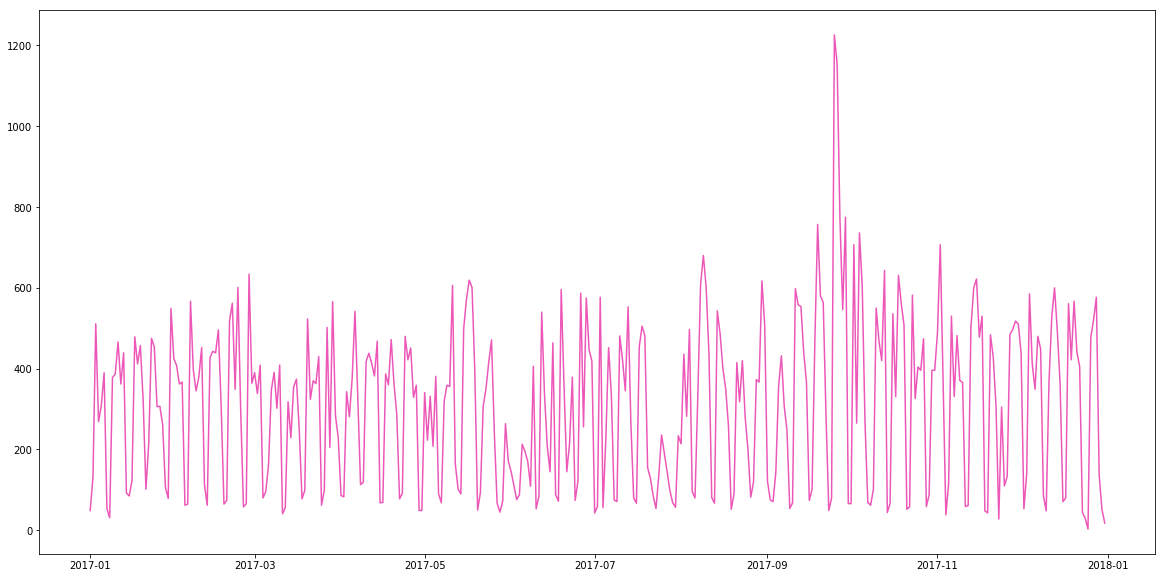

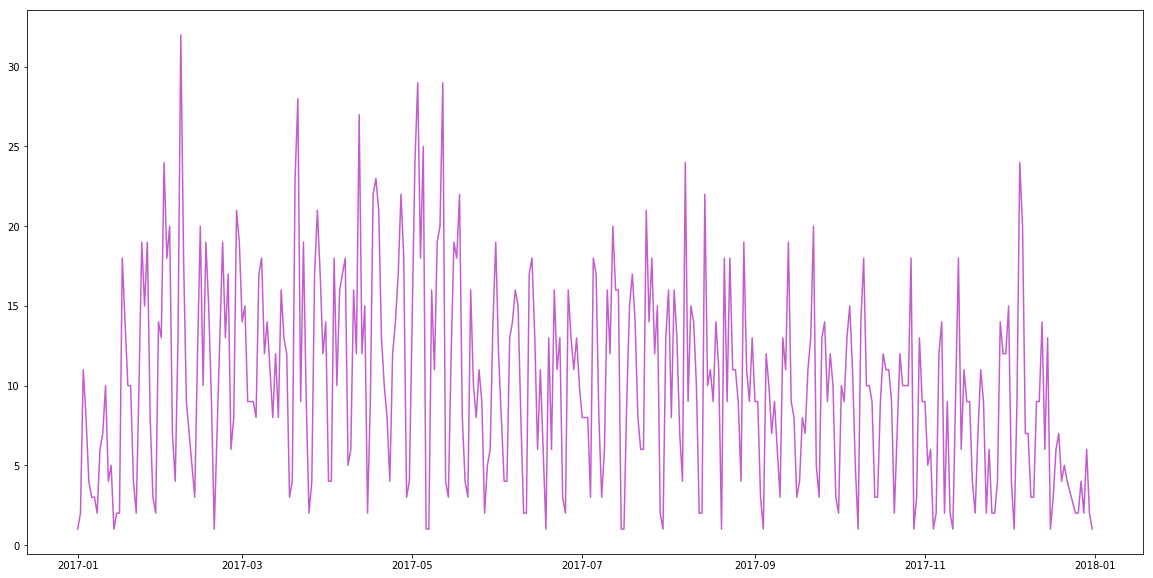

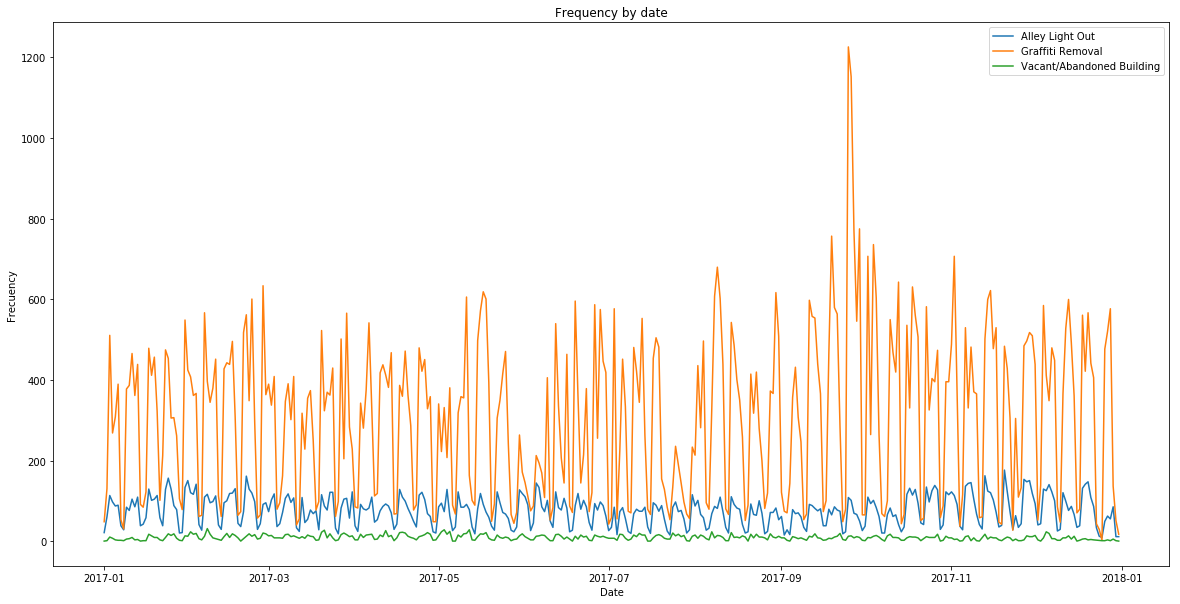

In [23]:
#Get frequencies of each by day
db = threeoneone_df
dates = db.groupby(['CREATION DATE F', 'TYPE OF SERVICE REQUEST']).size().reset_index(name='COUNT')

one = dates[dates['TYPE OF SERVICE REQUEST'] == "Alley Light Out"] 
two = dates[dates['TYPE OF SERVICE REQUEST'] == "Graffiti Removal"] 
three = dates[dates['TYPE OF SERVICE REQUEST'] == "Vacant/Abandoned Building"] 

x = one['CREATION DATE F']
y = one['COUNT']
plt.figure(figsize=(20, 10))
plt.plot(x, y, c=np.random.rand(3,))
plt.show()

x = two['CREATION DATE F']
y = two['COUNT']
plt.figure(figsize=(20, 10))
plt.plot(x, y, c=np.random.rand(3,))
plt.show()

x = three['CREATION DATE F']
y = three['COUNT']
plt.figure(figsize=(20, 10))
plt.plot(x, y, c=np.random.rand(3,))
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(one["CREATION DATE F"], one["COUNT"], label="Alley Light Out")
plt.plot(two["CREATION DATE F"], two["COUNT"], label="Graffiti Removal")
plt.plot(three["CREATION DATE F"], three["COUNT"], label="Vacant/Abandoned Building")

plt.xlabel("Date")
plt.ylabel("Frecuency")
plt.title("Frequency by date")

plt.legend()

plt.show()

#### Problem 1 - Part 3: Interesting findings:

1. The amount of calls reporting graffiti is considerably higher that for other services. 
2. Between September and November there seems to be a spike in reports to remove graffitti, while alley lights out reports are decreasing during the same period of time and actually increasing after November, a time in which reports of graffiti start decreasing. Vacant and Abandoned buildings reports seem to be more constant, but this is also due to the less amount of observations that we had. We find that the highest point for Abandoned buildings reports is during February and from there it statrs decreasing, which is contrasting to the trends of the other two kinds of reports. 
3. There is a contrasting difference between the different zip codes that report grafitti. It seems clear that the amount of reports are concentrated in some zip code clusters (which must be nighbohring), and in some zip codes, the amount of reports is almost similar and even lower to that of the other service requests. There are also zip codes with low levels of reports for all types of service requests. 
4. The response time seems to be higher for alley light out than for grafitti cleaning requests, which seems counterintuitive given that it would appear that cleaning grafitti is a more time consuming activity than re-storing a light in an alley. 
5. Completition date is missing from Abandoned/vacant buildings, difficulting the response time analysis, and making it harder to evaluate the government's response to this type of service requests. 

## PROBLEM 2

###### Functions for analysis of part 2

In [16]:
def get_stats(var, frame):
    
    frame["temp"] = frame[var].apply(lambda x: np.nan if (x == "-") else float(x))
    x = frame.groupby(["TYPE OF SERVICE REQUEST",'TRACT'])["temp"].mean()
    return x 

###### Analysis of part 2

In the present section, five socio-economic variables are analyzed in order to characterize demographically the neighbohrhoods where the service requests are presented. 
The variables are the following: 
1. "ONE RACE - WHITE": Corresponds to number of individuals identified as "white" as given from the census data. A methodological constraint was the inability to find this information as a percentage, in order to understand if a given place is predominantly white as compared to other ethnicities. However, we are using this variable to also understand how it compares when looking at the different types of service requests. 

2. "INCOME AND BENEFITS": Returns the total income and benefits recorded for the geographic area. A higher sd will help us identify more heterogeneity between geographic areas.

3. "EDUCATIONAL ATTAINMENT (25 AND OVER)": Represents the education attainmet from the population over 25 years old. 

4. "AVG HOUSEHOLD SIZE": Average size of a household

5. "SCHOOL ENROLLEMENT": Number of kids over 3 years old enrolled in school. 

We find that the blocks that have mostly people that identify as only from noe, race, have a higher concntration as denoted by the mean in places where 'Alley Light Out' has been reported as compared to 'Vacant/Abandoned Building'. The standard deviation however is bigger for 'Alley Light Out', indicating potentially more variation between the neighbohrhoods from where this kind of service failures are reported. 

Regarding income and benefits, both the mean and the standard variation are higher in the places reporting Alley Light Out, and we similar trends regarding educational attainment, both variables usually considered as indications of wellbeing. This seems to indicate that areas reporting 'Alley Light Out' service requests tend to have a higher socio-economic status. This is reinforced by the fact that household size is higher for the average corresponding to reports of Vacant and Abandoned buildings, and school enrollement is slightly higher as well. 

In [27]:
var_s = ["ONE RACE - WHITE","INCOME AND BENEFITS(MEAN)","EDUCATIONAL ATTAINMENT (25 AND OVER)","AVG HOUSEHOLD SIZE","SCHOOL ENROLLEMENT"]
#Normal stats:
for var in var_s: 
    x = get_stats(var, complete_frame)
    print(var, 'Alley Light Out', x['Alley Light Out'].describe(),"\n")
    print(var, 'Vacant/Abandoned Building', x['Vacant/Abandoned Building'].describe(),"\n", "---")

ONE RACE - WHITE Alley Light Out count    711.000000
mean      45.234037
std       33.538361
min        0.000000
25%        5.100000
50%       52.400000
75%       77.250000
max       97.300000
Name: temp, dtype: float64 

ONE RACE - WHITE Vacant/Abandoned Building count    403.000000
mean      31.076179
std       32.746645
min        0.000000
25%        1.750000
50%       10.500000
75%       62.300000
max       94.300000
Name: temp, dtype: float64 
 ---
INCOME AND BENEFITS(MEAN) Alley Light Out count      712.000000
mean      1293.665730
std        760.281881
min          0.000000
25%        770.500000
50%       1200.500000
75%       1646.250000
max      10143.000000
Name: temp, dtype: float64 

INCOME AND BENEFITS(MEAN) Vacant/Abandoned Building count     403.000000
mean     1183.106700
std       616.248029
min        88.000000
25%       719.500000
50%      1122.000000
75%      1542.000000
max      4296.000000
Name: temp, dtype: float64 
 ---
EDUCATIONAL ATTAINMENT (25 AND OVER) Alley

1. We see a slight increase in the mean of the population identifying as white from October to November both in places that reported mostly Alley Lights Out and those who reported Vacant and abandoned buildings. However, this trend is reversed from month 11 to month 12 for vacant and abandoned buildings, while it continues to be  positive for Alley Light Out. 

2. With regard to Income and benefits, there is no clear trend for any of the types of service requests analyzd. For Alley Light Out, it first increases and then decreases again, and we see the opposite happening for Vacant and abandoned buildings. In general, both reports increase from Month 10 to Month 12. 

3. Educational attainment increases for neighborhoods who report mostly Alley Light Out, while it decreases for those who report Vacant/Abandoned Buildings. 

4. There is no clear trend for the Average Household Size. 

5. School enrollement increases for Alley Light Out, and decreases for Vacant/Abandoned Building. 

While no trend is completely clear, and the changes are not necessarily big, we do see that, for the variables 2-5 that portray indicators of wellbeing and that change with time, the change seems to follow a positive trend for those in neighborhoods where Alley Lights Out are mostly reported, and those that report more Abandoned and Vacant Buildings portray a more negative trend. 

In [28]:
#Monthly stats:
complete_frame["MONTH"] = complete_frame["CREATION DATE F"].apply(lambda x: x.month)

for var in var_s: 
    print("----------\n", var ,"\n----------")
    
    for i in [10,11,12]:
        print("---\nMONTH", i ,"\n---")
        x = get_stats(var, complete_frame[(complete_frame["MONTH"] == i)])
        print('Alley Light Out', x['Alley Light Out'].mean(),"\n")
        print('Vacant/Abandoned Building', x['Vacant/Abandoned Building'].mean())

----------
 ONE RACE - WHITE 
----------
---
MONTH 10 
---
Alley Light Out 44.016753926701554 

Vacant/Abandoned Building 13.793288590604016
---
MONTH 11 
---
Alley Light Out 

/Users/crismacgregor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



43.86833910034602 

Vacant/Abandoned Building 17.221052631578946
---
MONTH 12 
---
Alley Light Out 44.999266055045865 

Vacant/Abandoned Building 15.76
----------
 INCOME AND BENEFITS(MEAN) 
----------
---
MONTH 10 
---
Alley Light Out 1301.1602787456445 

Vacant/Abandoned Building 1169.9127516778524
---
MONTH 11 
---
Alley Light Out 1317.4801381692573 

Vacant/Abandoned Building 1130.5187969924812
---
MONTH 12 
---
Alley Light Out 1311.043956043956 

Vacant/Abandoned Building 1145.557142857143
----------
 EDUCATIONAL ATTAINMENT (25 AND OVER) 
----------
---
MONTH 10 
---
Alley Light Out 2387.177700348432 

Vacant/Abandoned Building 2127.2751677852348
---
MONTH 11 
---
Alley Light Out 2415.663212435233 

Vacant/Abandoned Building 2119.4436090225563
---
MONTH 12 
---
Alley Light Out 2415.4725274725274 

Vacant/Abandoned Building 2083.792857142857
----------
 AVG HOUSEHOLD SIZE 
----------
---
MONTH 10 
---
Alley Light Out 2.837609075043629 

Vacant/Abandoned Building 2.9167114093959716


## PROBLEM 3

###### Functions for analysis of part 3

In [40]:
def find_zipcode(frame, st_address): 
    x = frame[(frame["STREET ADDRESS"] == st_address)]
    zip_code = x["ZIP CODE"].unique()[0]
    return zip_code

In [41]:
def get_relative_prob_fromzc(frame, zcode):
    z_f = frame[(frame["ZIP CODE"] == zcode)]
    print("\nType of Service Request: PERCENTAGE \n \n{}".format(z_f["TYPE OF SERVICE REQUEST"].value_counts(True)))

In [42]:
def get_relative_prob_fromtype(frame, s_kind, zcode1, zcode2):
    k_f = frame[(frame["TYPE OF SERVICE REQUEST"] == s_kind)]
    k_f = k_f[(k_f["ZIP CODE"] == zcode1)|(k_f["ZIP CODE"] == zcode2)]
    print("\nType of Service Request: PERCENTAGE \n \n{}".format(k_f["ZIP CODE"].value_counts(True)))

In [43]:
def get_relative_prob(a, total):
    return a/total 

###### Analysis of part 3

For 3600 W Roosevelt Rd, the most likely report will be Alley Light Out, given that it has the highest probability relative to the three possible options, when we filter the data to only use those reports that proceed from its neighborhood/area (in this case, we use Zip Code to make this approximation). The relative frequencies printed below:

In [45]:
zipc = find_zipcode(db, '3600 W ROOSEVELT RD')
get_relative_prob_fromzc(db, zipc)


Type of Service Request: PERCENTAGE 
 
Alley Light Out              0.572498
Graffiti Removal             0.290926
Vacant/Abandoned Building    0.136576
Name: TYPE OF SERVICE REQUEST, dtype: float64


For question 3b: zip codes for Garfield park and Uptown are  60624 and 60640, respectively. Given the relative frequencies printed belowe, we can think that since the probability is considerably higher, the call will most likely come from the zip code 60640 which corresponds to Uptown.

In [46]:
get_relative_prob_fromtype(db, "Graffiti Removal",60624,60640)


Type of Service Request: PERCENTAGE 
 
60640.0    0.887888
60624.0    0.112112
Name: ZIP CODE, dtype: float64


We use the conditional probability formula P(A|B) = P(A n B) / P (B), where P(A n B) is the probability that given the data the call is comming from a specific neighborhood (A) and is about grafitti (B), and P(B) is the probability that the call is concerning Grafitti. With the information provided, we conclude that it is 37% less likely that it came from Garfield. Conditional probabilities are printed below:

In [47]:
prob_grafitti = get_relative_prob(260, 1000)
prob_gar_grafitti = get_relative_prob(100, 1000)
prob_uptown_grafitti = get_relative_prob(160, 1000)

cond_garfield = get_relative_prob(prob_gar_grafitti, prob_grafitti)
cond_uptown = get_relative_prob(prob_uptown_grafitti, prob_grafitti)

print("Conditional probability for Garfield:", cond_garfield, "Conditional probability for Uptown:", cond_uptown)

dif = (cond_garfield -  cond_uptown) /  cond_uptown
print(dif)

Conditional probability for Garfield: 0.38461538461538464 Conditional probability for Uptown: 0.6153846153846154
-0.375
